In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('classic')
from random import shuffle
import pickle, datetime
import Preprocess as pp
import helper as hp

import keras
from keras.datasets import cifar10
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, Convolution2D, MaxPooling2D
from keras.layers.convolutional import ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras import optimizers
from keras.preprocessing import sequence
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import keras.backend as K
import tensorflow as tf

import  PIL.Image

Using TensorFlow backend.


### Loading a test Image

(1, 227, 227, 3) (1, 101)


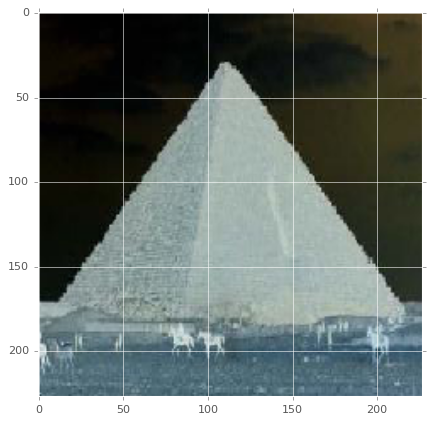

array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [2]:
HEIGHT, WIDTH = 227, 227

img_dir = './Datasets/101_ObjectCategories/'
categories = os.listdir(img_dir)
N_CATEGORY = len(categories)

cat_to_ind = dict()
for ind, cat in enumerate(categories):
    cat_to_ind[cat] = ind

all_img, all_label = [], []

category = 'pyramid'
files = [ f for f in os.listdir(img_dir + category)]
for file in files:
    filename = img_dir + category + '/' + file
    img = load_img(filename)
    img = img.resize((HEIGHT,WIDTH))
    all_img.append(img)
    all_label.append(cat_to_ind[category])
    
N_ALL = len(all_img)
N_CATEGORY = len(cat_to_ind)

x_all = np.empty((N_ALL, HEIGHT, WIDTH, 3), np.float32)
y_all = np_utils.to_categorical(all_label, N_CATEGORY)

for i in range(N_ALL):
    x_all[i,:,:,:] = all_img[i]

# # shuffle data
ind_list = [i for i in range(N_ALL)]
np.random.seed(1234)
np.random.shuffle(ind_list)
x_all = x_all[ind_list, :,:,:]
y_all = y_all[ind_list,]

N_TRAIN = 0
N_TEST = 1

# x_train = x_all[:N_TRAIN, :,:,:]
# y_train = y_all[:N_TRAIN,]

x_test = x_all[N_TRAIN:N_TRAIN + N_TEST, :,:,:]
y_test = y_all[N_TRAIN:N_TRAIN + N_TEST, ]

print(x_test.shape, y_test.shape)
plt.imshow(x_test[0,:,:,:])
plt.show()
y_test
# return x_train, y_train, x_test, y_test, N_CATEGORY

### Loading Model 

In [3]:
model = keras.models.load_model('./Datasets/Models/alexnet/alexNet_cifar100.h5')

count = 0
for layer in model.layers:
    print(count, layer.name, layer.input_shape, layer.output_shape)
    count += 1
    wts = layer.get_weights()
    for wt in wts:
        print(wt.shape)
    print('****************************************')

0 input_1 (None, 227, 227, 3) (None, 227, 227, 3)
****************************************
1 conv2d_1 (None, 227, 227, 3) (None, 55, 55, 96)
(11, 11, 3, 96)
(96,)
****************************************
2 max_pooling2d_1 (None, 55, 55, 96) (None, 27, 27, 96)
****************************************
3 batch_normalization_1 (None, 27, 27, 96) (None, 27, 27, 96)
(96,)
(96,)
(96,)
(96,)
****************************************
4 zero_padding2d_1 (None, 27, 27, 96) (None, 31, 31, 96)
****************************************
5 conv2d_2 (None, 31, 31, 96) (None, 27, 27, 256)
(5, 5, 96, 256)
(256,)
****************************************
6 max_pooling2d_2 (None, 27, 27, 256) (None, 13, 13, 256)
****************************************
7 batch_normalization_2 (None, 13, 13, 256) (None, 13, 13, 256)
(256,)
(256,)
(256,)
(256,)
****************************************
8 zero_padding2d_2 (None, 13, 13, 256) (None, 15, 15, 256)
****************************************
9 conv2d_3 (None, 15, 15, 25

In [4]:
img = tf.constant(x_test)
lbl = tf.constant(y_test)

# First Convolution layer
wts = model.get_layer('conv2d_1').get_weights()
wConv1 = tf.constant(wts[0])
bConv1 = tf.constant(wts[1])

conv1 = tf.nn.conv2d(img, wConv1, strides = [1,4,4,1], padding='VALID')
bias1 = conv1 + bConv1

relu1 = tf.nn.relu(bias1)

pool1 = tf.nn.max_pool(relu1, ksize = [1,3,3,1], strides = [1,2,2,1], padding="VALID")

wNorm1 = model.get_layer('batch_normalization_1').get_weights()
norm1 = tf.nn.batch_normalization(pool1, mean=wNorm1[2], variance=wNorm1[3], 
                                  offset=wNorm1[1], scale=wNorm1[0], variance_epsilon = 1e-2) 

# Second convolutoin Layer
wts = model.get_layer('conv2d_2').get_weights()
wConv2 = tf.constant(wts[0])
bConv2 = tf.constant(wts[1])

pad1 = tf.pad(norm1, paddings = [[0,0],[2,2],[2,2],[0,0]], mode='CONSTANT') 
conv2 =  tf.nn.conv2d(pad1, wConv2, strides = [1,1,1,1], padding='VALID')
bias2 =  conv2 + bConv2

relu2 = tf.nn.relu(bias2)
pool2 = tf.nn.max_pool(relu2, ksize = [1,3,3,1], strides = [1,2,2,1], padding="VALID")
wNorm2 = model.get_layer('batch_normalization_2').get_weights()
norm2 = tf.nn.batch_normalization(pool2, mean=wNorm2[2], variance=wNorm2[3], 
                                  offset=wNorm2[1], scale=wNorm2[0], variance_epsilon = 1e-2) 

# Third convolution Layer
wts = model.get_layer('conv2d_3').get_weights()
wConv3 = tf.constant(wts[0])
bConv3 = tf.constant(wts[1])

pad2 = tf.pad(norm2, paddings = [[0,0],[1,1],[1,1],[0,0]], mode='CONSTANT') 
conv3 =  tf.nn.conv2d(pad2, wConv3, strides = [1,1,1,1], padding='VALID')
bias3 =  conv3 + bConv3

relu3 = tf.nn.relu(bias3)

# Fourth convolution layer
wts = model.get_layer('conv2d_4').get_weights()
wConv4 = tf.constant(wts[0])
bConv4 = tf.constant(wts[1])

pad3 = tf.pad(relu3, paddings = [[0,0],[1,1],[1,1],[0,0]], mode='CONSTANT')

conv4 =  tf.nn.conv2d(pad3, wConv4, strides = [1,1,1,1], padding='VALID')
bias4 =  conv4 + bConv4

relu4 = tf.nn.relu(bias4)

# Fifth convolution layer
wts = model.get_layer('conv2d_5').get_weights()
wConv5 = tf.constant(wts[0])
bConv5 = tf.constant(wts[1])

pad4 = tf.pad(relu4, paddings = [[0,0],[1,1],[1,1],[0,0]], mode='CONSTANT')
conv5 =  tf.nn.conv2d(pad4, wConv5, strides = [1,1,1,1], padding='VALID')
bias5 =  conv5 + bConv5

relu5 = tf.nn.relu(bias5)

### Deconvolution of first convolution layer

In [5]:
sess = tf.InteractiveSession()

relu1_out = relu1.eval(feed_dict = {img:x_test, lbl:y_test})
conv1_out = tf.nn.relu(relu1_out)
img_org = tf.nn.conv2d_transpose(conv1_out, wConv1, output_shape=[1,227,227,3], 
                                strides = [1,4,4,1], padding='VALID')
img_org = sess.run(img_org)

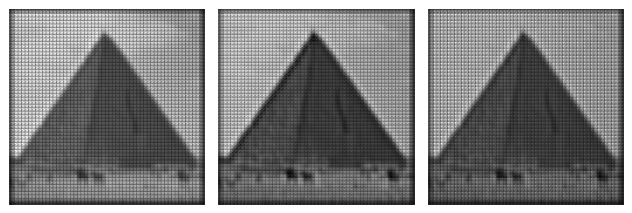

In [6]:
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(img_org[0,:,:,i], cmap='gray')
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
    plt.tight_layout()
plt.show()

## Convolution layer output

In [11]:
act1 = relu1.eval(feed_dict={img: x_test, lbl: y_test})

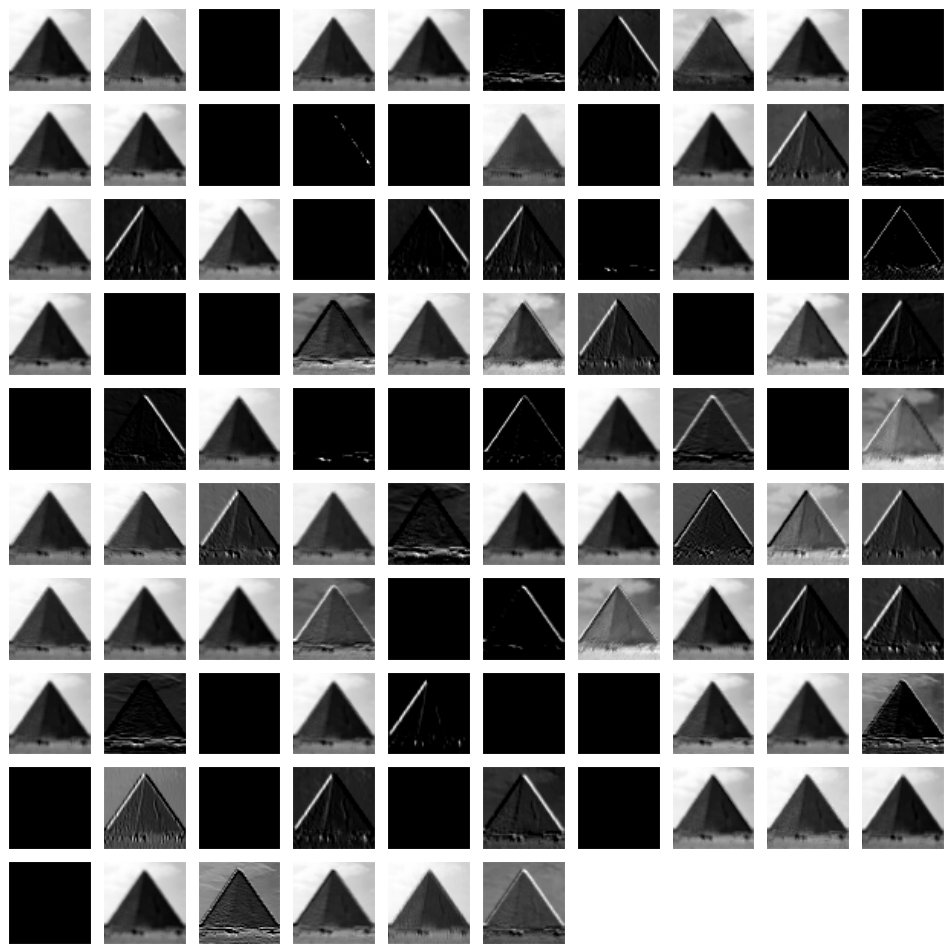

In [155]:
fig=plt.figure(figsize=(12,12))
for i in range(96):
    plt.subplot(10, 10, i+1)
    im = act1[0,:,:,i]
    plt.imshow(im, cmap='gray')
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
    plt.tight_layout()
plt.show()

## Deconvolving 2nd convolution Layer

In [7]:
def maxpool_arg(inp, out_shape):
    b, r, c, ch = inp.shape
    max_args = np.empty(out_shape, np.int8)

    for k in range(ch):
        c1 = 0
        for i in range(0, r-2, 2):
            c2 = 0
            for j in range(0, c-2, 2):
                temp = inp[0, i:i+3, j:j+3, k]
                max_args[0, c1, c2, k] = np.argmax(temp)
                c2 += 1
            c1 +=1
            
    return max_args

def unpool(ind_mat, val_mat, out_shape):
    out_mat = np.zeros(out_shape, np.float32)
    b, r,c,ch = out_shape
        
    for k in range(ch):
        c1 = 0
        for i in range(0, r-2, 2):
            c2 = 0
            for j in range(0, c-2, 2):
                ind = ind_mat[0, c1, c2, k]
                val = val_mat[0, c1, c2, k]
                coord = np.unravel_index(ind, (3,3))                
                out_mat[0, i + coord[0] , j + coord[1],k] = val
                
                c2 += 1
            c1 +=1
            
    return out_mat

In [8]:
sess = tf.InteractiveSession()

relu2_out = relu2.eval(feed_dict = {img:x_test, lbl:y_test})
conv2_out = tf.nn.relu(relu2_out)
pad1_out = tf.nn.conv2d_transpose(conv2_out, wConv2, output_shape=[1,31,31,96], 
                                strides = [1,1,1,1], padding='VALID')
norm1_out = tf.slice(pad1_out, [0,2,2,0], [1,27,27,96])
pool1_out = sess.run(norm1_out)

fwd_conv1_out = relu1.eval(feed_dict={img: x_test, lbl: y_test})
pool1_ind  = maxpool_arg(fwd_conv1_out, pool1_out.shape)

relu1_out = unpool(pool1_ind, pool1_out, fwd_conv1_out.shape)
conv1_out = tf.nn.relu(relu1_out)
img_org = tf.nn.conv2d_transpose(conv1_out, wConv1, output_shape=[1,227,227,3], 
                                strides = [1,4,4,1], padding='VALID')

img_org = sess.run(img_org)

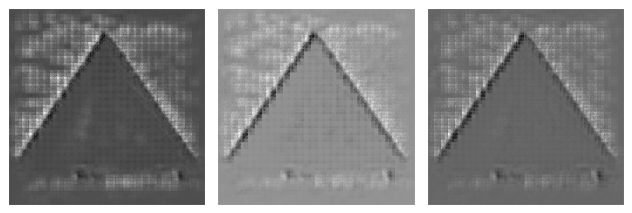

In [9]:
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(img_org[0,:,:,i], cmap='gray')
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
    plt.tight_layout()
plt.show()

### 2nd Convolution layer output

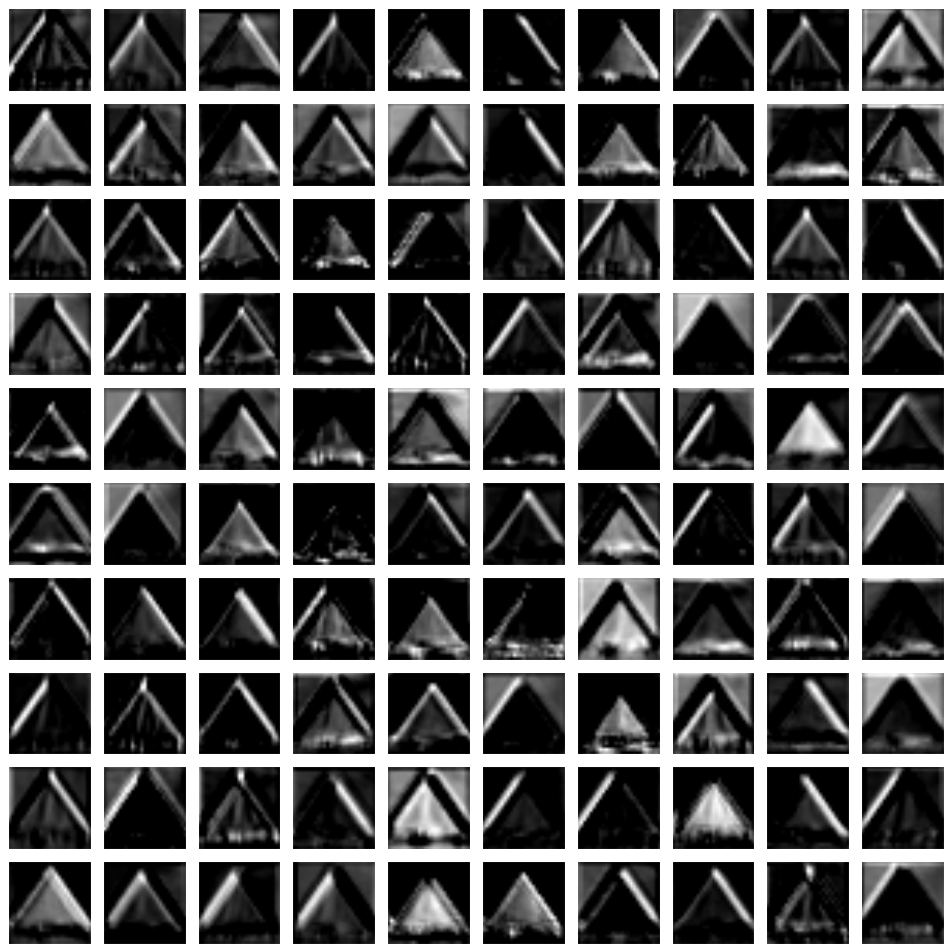

In [154]:
act2 = relu2.eval(feed_dict={img: x_test, lbl: y_test})

fig=plt.figure(figsize=(12,12))

for i in range(100):
    plt.subplot(10, 10, i+1)
    im = act2[0,:,:,i]
    plt.imshow(im, cmap='gray')
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
    plt.tight_layout()
plt.show()

## Deconvolution of 3rd Convolution Layer

In [10]:
sess = tf.InteractiveSession()

relu3_out = relu3.eval(feed_dict = {img:x_test, lbl:y_test})
conv3_out = tf.nn.relu(relu3_out)
pad2_out = tf.nn.conv2d_transpose(conv3_out, wConv3, output_shape=[1,15,15,256], 
                                strides = [1,1,1,1], padding='VALID')

norm2_out = tf.slice(pad2_out, [0,1,1,0], [1,13,13,256])
pool2_out = norm2_out

pool2_out = sess.run(pool2_out)

fwd_conv2_out = relu2.eval(feed_dict={img: x_test, lbl: y_test})
pool2_ind     = maxpool_arg(fwd_conv2_out, pool2_out.shape)

relu2_out = unpool(pool2_ind, pool2_out, fwd_conv2_out.shape)
conv2_out = tf.nn.relu(relu2_out)
pad1_out = tf.nn.conv2d_transpose(conv2_out, wConv2, output_shape=[1,31,31,96], 
                                strides = [1,1,1,1], padding='VALID')
norm1_out = tf.slice(pad1_out, [0,2,2,0], [1,27,27,96])
pool1_out = norm1_out
pool1_out = sess.run(pool1_out)

fwd_conv1_out = relu1.eval(feed_dict={img: x_test, lbl: y_test})
pool1_ind  = maxpool_arg(fwd_conv1_out, pool1_out.shape)

relu1_out = unpool(pool1_ind, pool1_out, fwd_conv1_out.shape)
conv1_out = tf.nn.relu(relu1_out)
img_org = tf.nn.conv2d_transpose(conv1_out, wConv1, output_shape=[1,227,227,3], 
                                strides = [1,4,4,1], padding='VALID')

img_org = sess.run(img_org)
print(img_org.shape)

(1, 227, 227, 3)


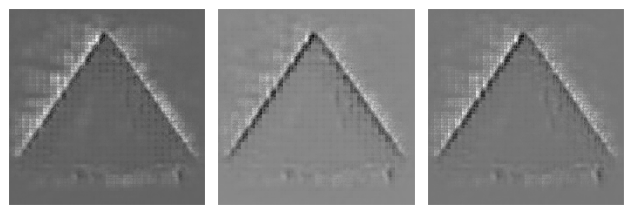

In [11]:
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(img_org[0,:,:,i], cmap='gray')
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
    plt.tight_layout()
plt.show()

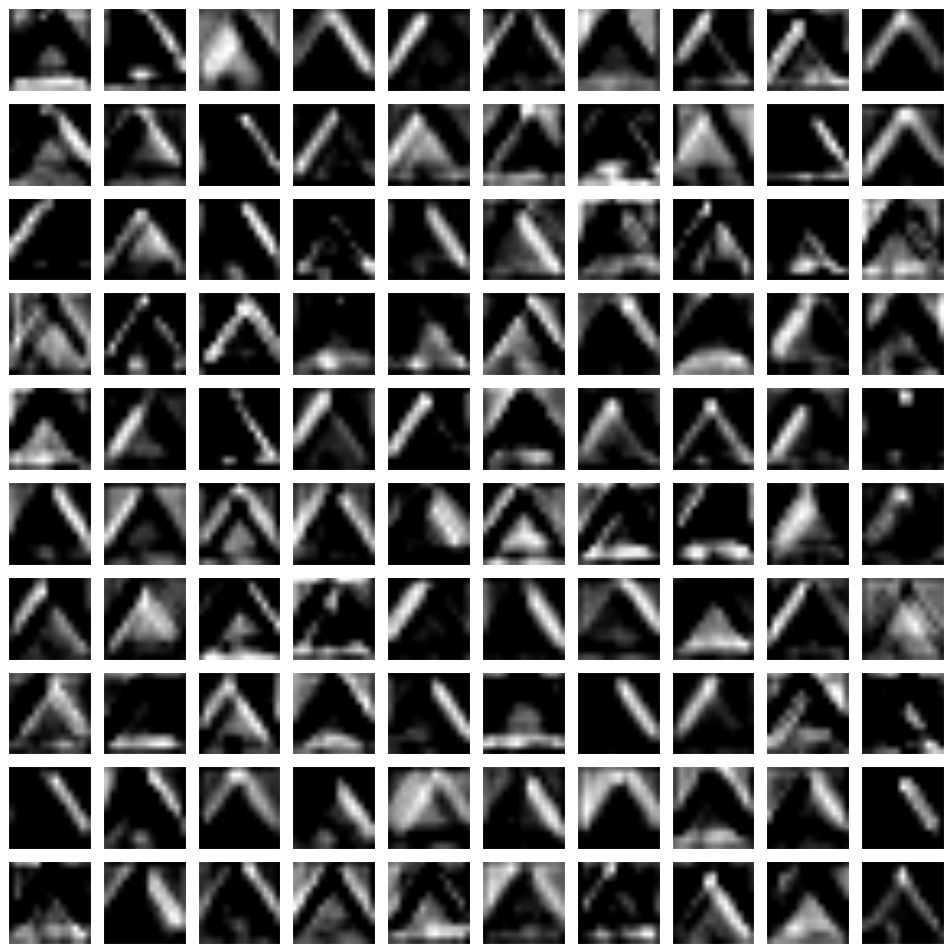

In [156]:
act3 = relu3.eval(feed_dict={img: x_test, lbl: y_test})

fig=plt.figure(figsize=(12,12))

for i in range(100):
    plt.subplot(10, 10, i+1)
    im = act3[0,:,:,i]
    plt.imshow(im, cmap='gray')
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
    plt.tight_layout()
plt.show()

## Deconvolution of 4th Convolution Layer

In [12]:
sess = tf.InteractiveSession()

relu4_out = relu4.eval(feed_dict = {img:x_test, lbl:y_test})
conv4_out = tf.nn.relu(relu4_out)
pad3_out = tf.nn.conv2d_transpose(conv4_out, wConv4, output_shape=[1,15,15,384], 
                                strides = [1,1,1,1], padding='VALID')

relu3_out = tf.slice(pad3_out, [0,1,1,0], [1,13,13,384])
conv3_out = tf.nn.relu(relu3_out)
pad2_out = tf.nn.conv2d_transpose(conv3_out, wConv3, output_shape=[1,15,15,256], 
                                strides = [1,1,1,1], padding='VALID')

norm2_out = tf.slice(pad2_out, [0,1,1,0], [1,13,13,256])
pool2_out = norm2_out

pool2_out = sess.run(pool2_out)

fwd_conv2_out = relu2.eval(feed_dict={img: x_test, lbl: y_test})
pool2_ind     = maxpool_arg(fwd_conv2_out, pool2_out.shape)

relu2_out = unpool(pool2_ind, pool2_out, fwd_conv2_out.shape)
conv2_out = tf.nn.relu(relu2_out)
pad1_out = tf.nn.conv2d_transpose(conv2_out, wConv2, output_shape=[1,31,31,96], 
                                strides = [1,1,1,1], padding='VALID')
norm1_out = tf.slice(pad1_out, [0,2,2,0], [1,27,27,96])
pool1_out = norm1_out
pool1_out = sess.run(pool1_out)

fwd_conv1_out = relu1.eval(feed_dict={img: x_test, lbl: y_test})
pool1_ind  = maxpool_arg(fwd_conv1_out, pool1_out.shape)

relu1_out = unpool(pool1_ind, pool1_out, fwd_conv1_out.shape)
conv1_out = tf.nn.relu(relu1_out)
img_org = tf.nn.conv2d_transpose(conv1_out, wConv1, output_shape=[1,227,227,3], 
                                strides = [1,4,4,1], padding='VALID')

img_org = sess.run(img_org)
print(img_org.shape)

(1, 227, 227, 3)


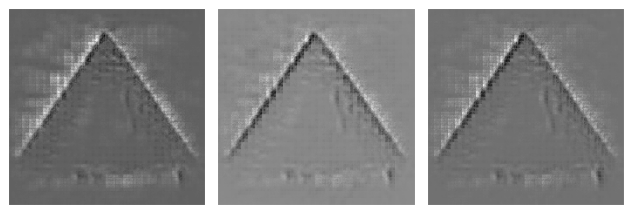

In [13]:
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(img_org[0,:,:,i], cmap='gray')
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
    plt.tight_layout()
plt.show()

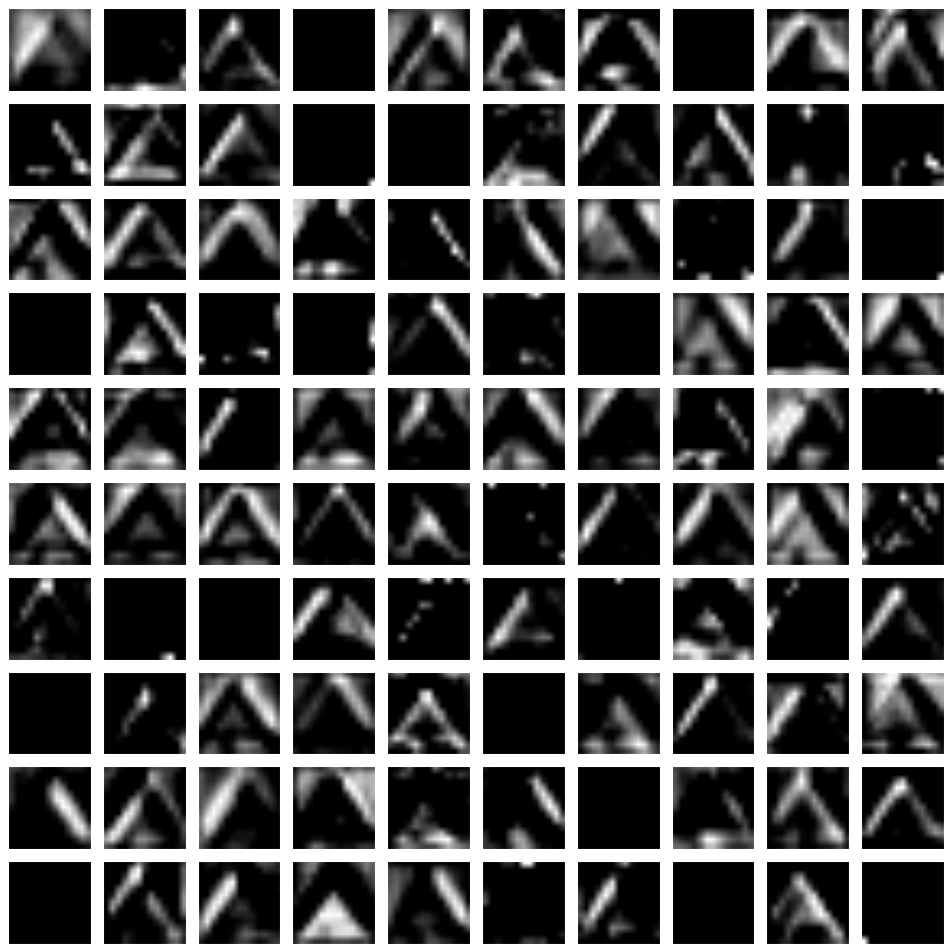

In [157]:
act4 = relu4.eval(feed_dict={img: x_test, lbl: y_test})

fig=plt.figure(figsize=(12,12))

for i in range(100):
    plt.subplot(10, 10, i+1)
    im = act4[0,:,:,i]
    plt.imshow(im, cmap='gray')
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
    plt.tight_layout()
plt.show()

## Deconvolution of 5th Convolution layer

In [14]:
sess = tf.InteractiveSession()

relu5_out = relu5.eval(feed_dict = {img:x_test, lbl:y_test})
conv5_out = tf.nn.relu(relu5_out)
pad4_out = tf.nn.conv2d_transpose(conv5_out, wConv5, output_shape=[1,15,15,384], 
                                strides = [1,1,1,1], padding='VALID')

relu4_out = tf.slice(pad4_out, [0,1,1,0], [1,13,13,384])
conv4_out = tf.nn.relu(relu4_out)
pad3_out = tf.nn.conv2d_transpose(conv4_out, wConv4, output_shape=[1,15,15,384], 
                                strides = [1,1,1,1], padding='VALID')

relu3_out = tf.slice(pad3_out, [0,1,1,0], [1,13,13,384])
conv3_out = tf.nn.relu(relu3_out)
pad2_out = tf.nn.conv2d_transpose(conv3_out, wConv3, output_shape=[1,15,15,256], 
                                strides = [1,1,1,1], padding='VALID')

norm2_out = tf.slice(pad2_out, [0,1,1,0], [1,13,13,256])
pool2_out = norm2_out

pool2_out = sess.run(pool2_out)

fwd_conv2_out = relu2.eval(feed_dict={img: x_test, lbl: y_test})
pool2_ind     = maxpool_arg(fwd_conv2_out, pool2_out.shape)

relu2_out = unpool(pool2_ind, pool2_out, fwd_conv2_out.shape)
conv2_out = tf.nn.relu(relu2_out)
pad1_out = tf.nn.conv2d_transpose(conv2_out, wConv2, output_shape=[1,31,31,96], 
                                strides = [1,1,1,1], padding='VALID')
norm1_out = tf.slice(pad1_out, [0,2,2,0], [1,27,27,96])
pool1_out = norm1_out
pool1_out = sess.run(pool1_out)

fwd_conv1_out = relu1.eval(feed_dict={img: x_test, lbl: y_test})
pool1_ind  = maxpool_arg(fwd_conv1_out, pool1_out.shape)

relu1_out = unpool(pool1_ind, pool1_out, fwd_conv1_out.shape)
conv1_out = tf.nn.relu(relu1_out)
img_org = tf.nn.conv2d_transpose(conv1_out, wConv1, output_shape=[1,227,227,3], 
                                strides = [1,4,4,1], padding='VALID')

img_org = sess.run(img_org)
print(img_org.shape)

(1, 227, 227, 3)


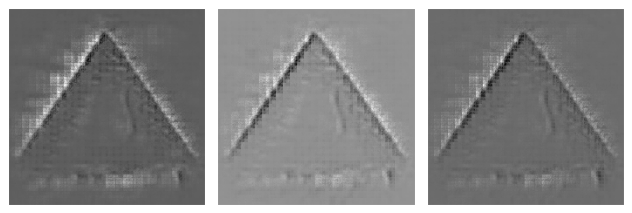

In [15]:
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(img_org[0,:,:,i], cmap='gray')
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
    plt.tight_layout()
plt.show()

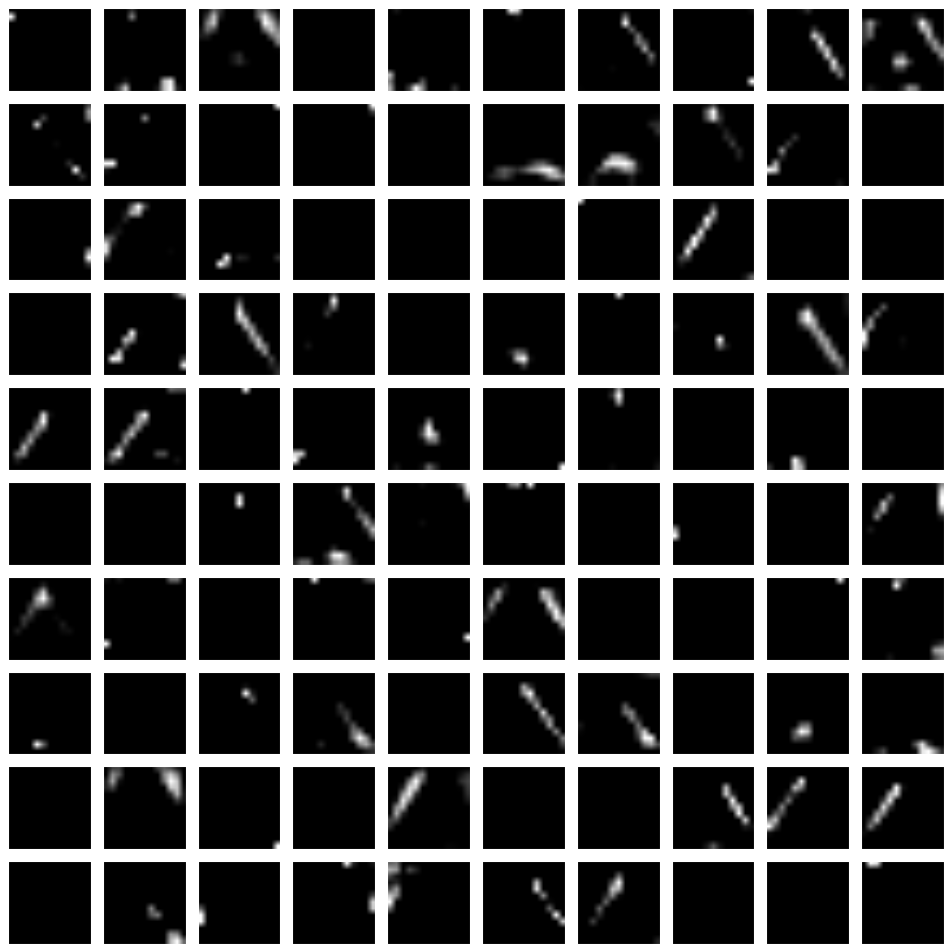

In [178]:
act5 = relu5.eval(feed_dict={img: x_test, lbl: y_test})

fig=plt.figure(figsize=(12,12))

for i in range(100):
    plt.subplot(10, 10, i+1)
    im = act5[0,:,:,i]
    plt.imshow(im, cmap='gray')
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
    plt.tight_layout()
plt.show()